# Clusterização textual TJRN


## Introdução

Este notebook demonstra a implementação de um clustering textual baseado no *stack* dos algoritmos *Self Organizing Map* (Mapa de Kohonen) e K-Means.

O Mapa de Kohonen é uma rede neural capaz de aprender de forma não-supervisionada a topologia (organização) dos dados em um espaço dimensional. Ele é composto por um grid bidimensional de neurônios que são ajustados durante o treinamento. Pode ser utilizado tanto para redução de dimensionalidade como para clustering.

O K-Means é um algoritmo clássico de clustering que agrupa pontos de um espaço baseando-se centróides. O seu treinamento é feito pela movimentação iterativa dos centróides no método EM (*Expectation-Maximization*), onde busca-se minimizar uma função objetivo, a Inércia.


---

A base de dados utilizada no experimento é uma coleção de 30 mil documentos de movimentações judiciais do Tribunal de Justiça do Rio Grande do Norte (TJRN). A base é originalmente dividida entre 10 classes, que utilizaremos apenas para avaliar quantitativamente nosso modelo com métricas supervisionadas.



## Bibliotecas

**Instalando e importando as bibliotecas necessárias**

- numpy - 1.19.5
- pandas - 1.1.5
- nltk - 3.2.5
- sklearn 
- somoclu - 1.7.5.1

In [ ]:
!pip install somoclu

In [ ]:
!pip show somoclu 

Name: somoclu
Version: 1.7.5.1
Summary: Massively parallel implementation of self-organizing maps
Home-page: https://somoclu.readthedocs.io/
Author: Peter Wittek, Shi Chao Gao
Author-email: 
License: GPL3
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, numpy, matplotlib
Required-by: 


In [ ]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import somoclu
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import axes_style

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Dados

Os dados importados neste notebook já passaram por um pré-processamento prévio.

**Pré processamentos**
- Remoção de caracteres especiais
- Remoção de números
- Lowercase

In [ ]:
!unzip 10_classes_preprocessado.zip

Archive:  10_classes_preprocessado.zip
  inflating: 10_classes_preprocessado.csv  


**Separando os textos dos labels**

In [ ]:
data_csv = pd.read_csv('10_classes_preprocessado.csv')
data = list( data_csv['data'].values.astype('str') )
label = np.array( data_csv['label'] )

## Algoritmos

Nesta seção nos dedicamos à implementação dos algoritmos em si.

### TF-IDF

**Definindo os parâmetros do TF-IDF**

In [ ]:
TF_IDF_PARAMS = {'stop_words':stopwords.words('portuguese'), 
                 'ngram_range':(1,2),
                 'max_df':0.90,
                 'min_df':0.021
                 }

In [ ]:
tfidf = TfidfVectorizer().set_params(**TF_IDF_PARAMS)

**Vetorizando os textos**

In [ ]:
%%time
data_tfidf = tfidf.fit_transform(data)
data_tfidf_dense = np.array(data_tfidf.todense(), dtype='float32')

CPU times: user 28.9 s, sys: 1.36 s, total: 30.2 s
Wall time: 30.3 s


In [ ]:
data_tfidf_dense.shape

(30000, 3359)

### SOM

SOM ou Mapa de Kohonen é o primeiro componente do nosso modelo.

**Definindo os parâmetros do SOM**
- 2500 neurônios
- Grid retangular 50x50 

In [ ]:
som_dim = (50,50)

In [ ]:
## Map initialization
%%time

np.random.seed(214)

data_means = np.mean(data_tfidf_dense, axis=0)
data_stds = 16*np.std(data_tfidf_dense, axis=0)

initial_codebook = np.random.randn( som_dim[0]*som_dim[1], data_tfidf_dense.shape[1] )
initial_codebook += data_means
initial_codebook = np.squeeze( ((np.expand_dims(initial_codebook, axis=1) )*data_stds), axis=1)

initial_codebook = np.sort(initial_codebook)
initial_codebook = initial_codebook.reshape( (som_dim[0], som_dim[1], 
                                              data_tfidf_dense.shape[1]) )

CPU times: user 1.21 s, sys: 6.5 ms, total: 1.22 s
Wall time: 1.23 s


In [ ]:
%%time
epochs=5

try:
  initial_codebook = np.load('codebook50x50_1.npy')
  bmus = np.load('bmus50x50_1.npy')
  som_model = somoclu.Somoclu(som_dim[0], 
                            som_dim[1],
                            initialcodebook=initial_codebook,
                            compactsupport=False,
                            )
  som_model.bmus = bmus
  epochs=0
except:
  som_model = somoclu.Somoclu(som_dim[0], 
                              som_dim[1],
                              compactsupport=False,
                              initialization="pca"
                              )


som_model.train(data_tfidf_dense,
                radius0=0.8*max(som_dim[0], som_dim[1]),
                epochs=epochs)

In [ ]:
data_bmu = som_model.bmus

In [ ]:
np.save(f'bmus{som_dim[0]}x{som_dim[1]}.npy', data_bmu)
np.save(f'codebook{som_dim[0]}x{som_dim[1]}.npy', som_model.codebook)




### KMeans - Pós processamento

O K-Means determina o número final de clusters.
Foi decidido criar um modelo com 8 clusters, valor que se mostrou adequado após experimentos.

In [ ]:
%%time
kmeans_clt = KMeans(8 , n_init=150, random_state=214)

true_labels = np.array(label)
som_model.cluster(kmeans_clt)
pred_labels = np.array([ som_model.clusters[ bmu[0], bmu[1] ] for bmu in som_model.bmus ])

CPU times: user 2min 46s, sys: 52.6 s, total: 3min 39s
Wall time: 2min 31s


In [ ]:
def view_umatrix_clusters(som_model, original_text_data,
                          pred_labels, topn=10 ):
  
  n_clusters = len(np.unique(pred_labels))
  fig, ax = plt.subplots(1, 2, figsize=(15,30))
  
  counter = TfidfVectorizer().set_params(**TF_IDF_PARAMS)
  word_counts = np.float32(counter.fit_transform(original_text_data).todense())
  reversed_dict = { value:key for key,value in counter.vocabulary_.items() }
  
  for cluster in np.unique( som_model.clusters ):
    coord = np.mean( np.argwhere(som_model.clusters == cluster), axis=0)
    ax[0].text(int(coord[1]), int(coord[0]),
               str(cluster), fontsize=20,
               ha='center', va='center', 
               bbox={'boxstyle':'square',
                     'facecolor':'white'} )
  

  ax[0].imshow(som_model.clusters)
  ax[0].set_title("Clusters\n", fontsize=25)
  
  ax[1].imshow(som_model.umatrix)
  ax[1].set_title("SOM U-Matrix\n", fontsize=25)

  plt.show()

**Visualizando os clusters sobre a U-Matrix**

A U-Matrix é uma forma visual resumida de visualizar a interação entre os neurônios do mapa. Pontos escuros significam pequenas distâncias entre os neurônios, ou seja, áreas muito densas que indicam potenciais clusters.



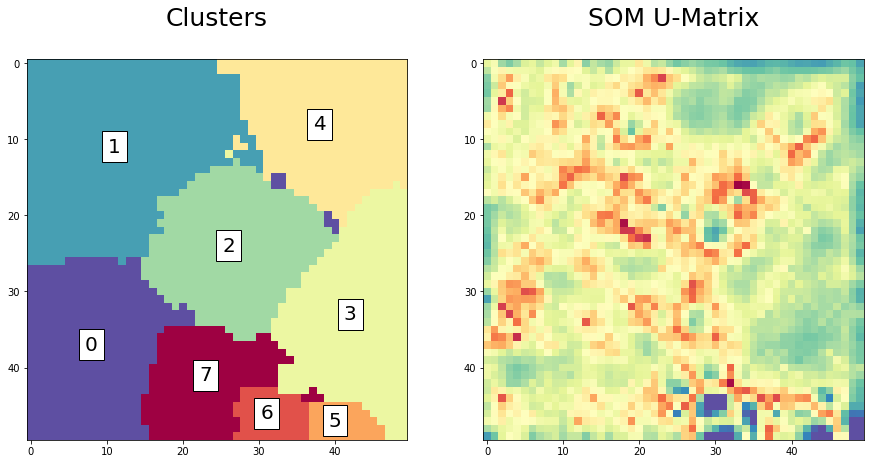

In [ ]:
view_umatrix_clusters(som_model, data, kmeans_clt.labels_, topn=200)

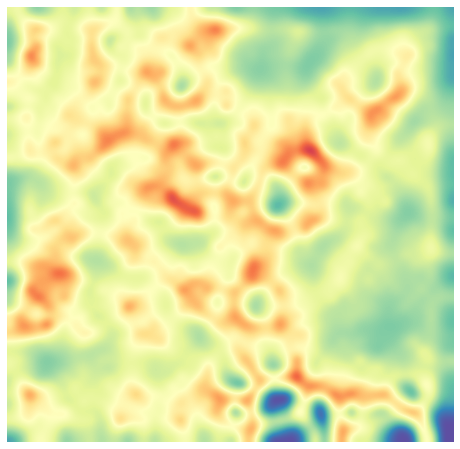

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_model.view_umatrix()

## Métricas

Nesta seção, nos dedicamos a avaliar o modelo.

- **Silhouette Score e Silhouette Sample Plot**
- **Contingency Matrix**
- **Pureza e incerteza em classes parecidas**
- **Palavras mais frequentes por cluster**


### Silhouette Samples

A visualização do *Silhouette Score* nos permite avaliar como cada entrada se relaciona com seu proprio cluster.

In [ ]:
def plot_silhouette_samples(X, pred_labels):
  n_clusters = len(np.unique(pred_labels))

  fig, (ax) = plt.subplots(1, 1, figsize=(8,8))
  
  ax.set_xlim([-0.1, 1])
  ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  silhouette_avg = silhouette_score(X, pred_labels)
  sample_silhouette_values = silhouette_samples(X, pred_labels)

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[pred_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
  
    ax.fill_betweenx(np.arange(y_lower, y_upper), 
                     0, ith_cluster_silhouette_values )
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
            ha='center', va='center', fontsize=12,
            bbox={'boxstyle':'square',
                  'facecolor':'white'})
    y_lower = y_upper + 10
  
  ax.set_title(f"The silhouette score plot for the {n_clusters} clusters.\n",fontsize=20)
  ax.set_xlabel("Silhouette coefficient values",fontsize=18)
  ax.set_ylabel("Cluster",fontsize=18)
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax.set_yticks([])
  ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  return ax

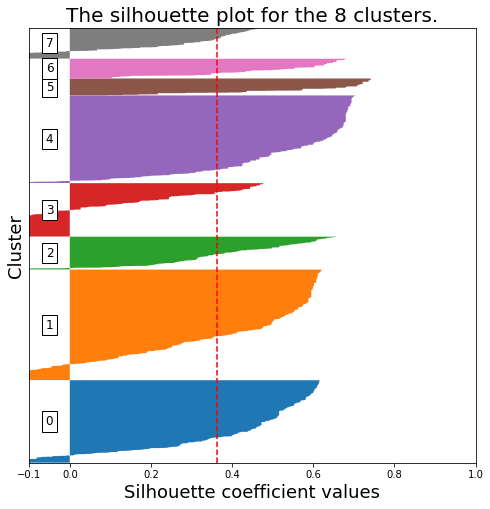

In [ ]:
plot_silhouette_samples(data_bmu, pred_labels)

### Contingency Matrix

A matriz de contingência é uma matriz descritiva da distribuição das classes originais sobre os clusters criados (e *vice-versa*).

Ela pode ser entendida como a 'equivalente' da matriz de confusão nos problemas de classificação. Entretanto, não há blusca por diagonalidade, mas sim por *pureza* e *homogeneidade*.

In [ ]:
def data_contingency_matrix(true_labels, pred_labels):
  
  fig, (ax) = plt.subplots(1, 1, figsize=(8,8))

  n_clusters = len(np.unique(pred_labels))
  n_classes = len(np.unique(true_labels))
  label_names =  np.unique(true_labels)
  label_names.sort()

  contingency_matrix = np.zeros( (n_classes, n_clusters) )

  for i, true_label in enumerate(label_names):
    for j in range(n_clusters):
      contingency_matrix[i, j] = np.sum(np.logical_and(pred_labels==j, true_labels==true_label))

  heatmap(contingency_matrix.astype(int), ax=ax,
          annot=True, annot_kws={"fontsize":14}, fmt='d')
  
  ax.set_xlabel("Clusters", fontsize=18)
  ax.set_xticks( [i+0.5 for i in range(n_clusters)] )
  ax.set_xticklabels([i for i in range(n_clusters)], fontsize=14)
  
  ax.set_ylabel("Original classes", fontsize=18)
  ax.set_yticks( [i+0.5 for i in range(n_classes)] )
  ax.set_yticklabels(label_names, fontsize=14, va="center")

  ax.set_title("Contingency Matrix\n", ha='center', fontsize=20)

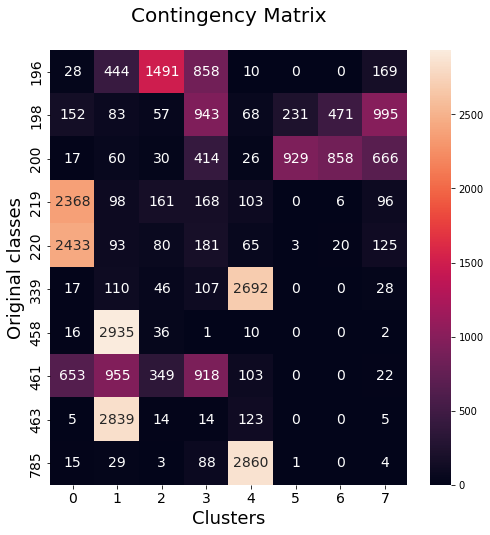

In [ ]:
data_contingency_matrix(true_labels, pred_labels)

### Most Important Words

Visualizando as palavras mais importantes em cada cluster.

> Nesse contexto 'mais importante' significa 'maior TF-IDF médio'
 



In [ ]:
def plot_most_important_words(original_text_data, pred_labels, topn=10):

  n_clusters = len(np.unique(pred_labels))
  fig, (ax) = plt.subplots(1, 1)

  counter = TfidfVectorizer().set_params(**TF_IDF_PARAMS)
  word_counts = counter.fit_transform(original_text_data)
  reversed_dict = { value:key for key,value in counter.vocabulary_.items() }

  ax.set_yticks( [0, topn+4] )
  ax.set_xticks( list(range(n_clusters)) )
  ax.axis('off')

  for i in range(n_clusters):
    ith_cluter_word_sum = np.mean(word_counts[np.argwhere(pred_labels==i).flatten()], axis=0)
    
    word_ids = np.argsort( ith_cluter_word_sum )[0, -topn:]
    words=""

    for j, key in enumerate( np.nditer(word_ids) ):
      words = words + reversed_dict[int(key)]+"\n"
    
    ax.text(2*i, topn, words, ha='center', va='top')
    ax.text(2*i, topn+2, f"Cluster {i}", ha='center', va='center')

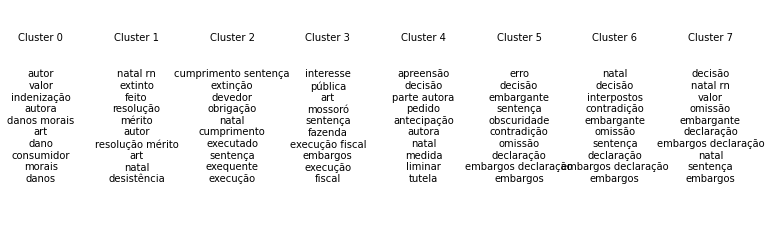

In [ ]:
plot_most_important_words(data, pred_labels, topn=10)